# 電波データを統合してプロット

# 1

- HF帯アンテナ (13.8-41.2MHz)
- IPRT (100-500MHz)

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cdflib
from astropy.io import fits
import datetime as dt

import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

# ファイルパス（適宜パスを変更してください）
hf_file_path = "/home/kinno-7010/Research/Radio data/HF_plot/Rawdata/it_h1_hf_20220613_v01.cdf"

iprt_file_path = "/home/kinno-7010/Research/Radio data/IPRT/Rawdata/20220613_IPRT.fits"

### １．HF側（CDFファイル）のデータ読み込み・正規化・共通時間での切り出し

In [2]:
# CDFファイルを読み込み
cdf_file = cdflib.CDF(hf_file_path)

# 必要な変数を取得
epoch = cdf_file.varget('Epoch')           # 時刻（数値）
frequency_hf = cdf_file.varget('Frequency')   # 周波数 [Hz]
# ここでは RH を用いる（LH でも可）
hf_intensity = cdf_file.varget('RH')          # 強度，shape: (時刻, 周波数)

# 周波数を MHz 単位に変換
frequency_hf_mhz = frequency_hf / 1e6

# 全体平均で正規化（正規化後は平均1前後となる）
hf_mean = np.mean(hf_intensity)
hf_norm = hf_intensity / hf_mean

# 時刻の変換（サンプルコードでは base_time からの ms オフセットとしています）
base_time = pd.Timestamp('2022-06-13 00:00:00')
time_hf = base_time + pd.to_timedelta(epoch - epoch[0], unit='ms')



### ２．IPRT側（FITSファイル）のデータ読み込み・正規化・共通時間での切り出し

In [3]:
# FITSファイルを読み込む
with fits.open(iprt_file_path) as hdul:
    iprt_data = hdul[0].data   # データ部分，想定する形状は (Polarization, NAXIS2, NAXIS1)
    iprt_header = hdul[0].header

# 多くの場合，データは (pol, freq, time) の順．ここでは Polarization 0（例えば RCP）を採用
iprt_intensity = iprt_data[0, :, :]   # shape: (周波数, 時刻)

# 全体平均で正規化
iprt_mean = np.mean(iprt_intensity)
iprt_norm = iprt_intensity / iprt_mean

# ヘッダー情報から時刻軸を生成
# DATE-OBS, TIME-OBS, DATE-END, TIME-END から開始・終了時刻を作成
start_time_iprt = pd.Timestamp(f"{iprt_header['DATE-OBS']} {iprt_header['TIME-OBS']}")
end_time_iprt   = pd.Timestamp(f"{iprt_header['DATE-END']} {iprt_header['TIME-END']}")
num_time_iprt = iprt_header['NAXIS1']
# 等間隔の時刻軸を生成（FITS の時刻は等間隔と仮定）
time_iprt_full = pd.date_range(start=start_time_iprt, end=end_time_iprt, periods=num_time_iprt)

# ヘッダー情報から周波数軸を生成
freq_start_iprt = iprt_header['CRVAL2']      # 開始周波数 [MHz]（例：100.000）
num_freq_iprt = iprt_header['NAXIS2']
freq_step_iprt = iprt_header['CDELT2']         # 周波数刻み [MHz]（例：0.976562）
freq_iprt = np.linspace(freq_start_iprt,
                        freq_start_iprt + freq_step_iprt*(num_freq_iprt-1),
                        num_freq_iprt) 

### ３．統合プロットの作成

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_combined_dynamic_spectrum(start_time, end_time, vmin, vmax):
    """
    指定した共通時間の範囲とカラースケール（vmin, vmax）を用いて，
    HF（13.8～41.2 MHz）とIPRT（100～500 MHz）のダイナミックスペクトルをプロットする関数．

    引数:
      start_time : 開始時刻（例："2022-06-13 03:00:00" または pd.Timestamp）
      end_time   : 終了時刻（例："2022-06-13 04:30:00" または pd.Timestamp）
      vmin       : カラースケールの下限
      vmax       : カラースケールの上限
    """
    # 共通時間を pd.Timestamp に変換（既に Timestamp の場合はそのままでOK）
    common_start = pd.Timestamp(start_time)
    common_end   = pd.Timestamp(end_time)

    # HF側の共通時間に含まれるインデックスを抽出
    mask_hf = (time_hf >= common_start) & (time_hf <= common_end)
    time_hf_common = time_hf[mask_hf]
    hf_norm_common = hf_norm[mask_hf, :]   # shape: (時刻数, 周波数数)

    # IPRT側の共通時間に含まれるインデックスを抽出
    mask_iprt = (time_iprt_full >= common_start) & (time_iprt_full <= common_end)
    time_iprt_common = time_iprt_full[mask_iprt]
    iprt_norm_common = iprt_norm[:, mask_iprt]  # shape: (周波数数, 時刻数)


    ##########################################################
    # プロット作成
    fig, ax = plt.subplots(figsize=(12, 8))

    # HF側プロット（下部ブロック：13.8～41.2 MHz）
    extent_hf = [
        mdates.date2num(time_hf_common[0]),
        mdates.date2num(time_hf_common[-1]),
        frequency_hf_mhz[0],  # 先頭が約13.8 MHz
        frequency_hf_mhz[-1]  # 最後が約41.2 MHz
    ]
    im_hf = ax.imshow(hf_norm_common.T, aspect='auto', origin='lower',
                      extent=extent_hf, cmap='jet', vmin=vmin, vmax=vmax)

    # IPRT側プロット（上部ブロック：100～500 MHz）
    extent_iprt = [
        mdates.date2num(time_iprt_common[0]),
        mdates.date2num(time_iprt_common[-1]),
        freq_iprt[0],    # 例：100 MHz
        freq_iprt[-1]    # 例：500 MHz
    ]
    im_iprt = ax.imshow(iprt_norm_common, aspect='auto', origin='lower',
                        extent=extent_iprt, cmap='jet', vmin=vmin, vmax=vmax)

    # 軸設定：x軸は共通時間、y軸は HF と IPRT 両方のレンジ
    ax.set_xlim(mdates.date2num(common_start), mdates.date2num(common_end))
    ax.set_ylim(13.8, 500)
    ax.set_xlabel('Time (UT)', fontsize=14)
    ax.set_ylabel('Frequency (MHz)', fontsize=14)
    ax.set_title('HF antenna (14-41 MHz) + IPRT (100-500 MHz)', fontsize=20)
    ax.set_yscale('log')  # y軸を対数目盛に変更

    # x 軸の時刻表示整形
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

    # カラーバーの追加（HF側の imshow を基準にしています）
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = plt.colorbar(im_hf, cax=cax)
    cbar.set_label('Normalized Intensity', fontsize=14)

    plt.tight_layout()
    plt.show()


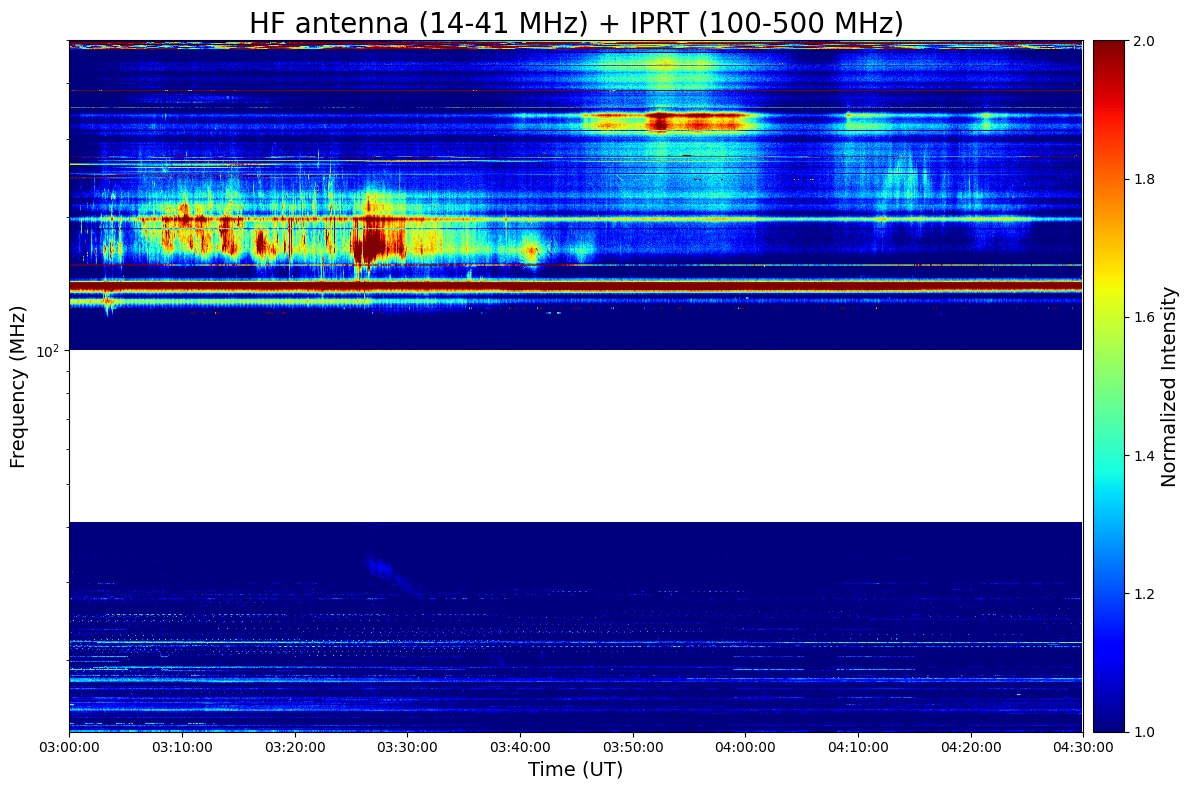

In [16]:
plot_combined_dynamic_spectrum(start_time="2022-06-13 03:00:00",
                               end_time="2022-06-13 04:30:00",
                               vmin=1.0,
                               vmax=2.0
                               )


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter

def plot_combined_dynamic_spectrum(start_time, end_time,
                                   vmin_hf=None, vmax_hf=None,
                                   vmin_iprt=None, vmax_iprt=None):
    """
    指定した共通時間の範囲と HF, IPRT 各側のカラースケールを用いて，
    HF（13.8～41.2 MHz）と IPRT（100～500 MHz）のダイナミックスペクトルを
    規格化せずにプロットする関数．

    引数:
      start_time : 開始時刻（例："2022-06-13 03:00:00" または pd.Timestamp）
      end_time   : 終了時刻（例："2022-06-13 04:30:00" または pd.Timestamp）
      vmin_hf    : HF 側のカラースケール下限（None の場合はデータの 5 パーセンタイル）
      vmax_hf    : HF 側のカラースケール上限（None の場合はデータの 95 パーセンタイル）
      vmin_iprt  : IPRT 側のカラースケール下限（None の場合はデータの 5 パーセンタイル）
      vmax_iprt  : IPRT 側のカラースケール上限（None の場合はデータの 95 パーセンタイル）
    """
    # 共通時間を pd.Timestamp に変換
    common_start = pd.Timestamp(start_time)
    common_end   = pd.Timestamp(end_time)

    # -----------------------
    # HF 側のデータ抽出（規格化せず元の強度を使用）
    # -----------------------
    mask_hf = (time_hf >= common_start) & (time_hf <= common_end)
    time_hf_common = time_hf[mask_hf]
    hf_data_common = hf_intensity[mask_hf, :]   # shape: (時刻数, 周波数数)

    # -----------------------
    # IPRT 側のデータ抽出（規格化せず元の強度を使用）
    # -----------------------
    mask_iprt = (time_iprt_full >= common_start) & (time_iprt_full <= common_end)
    time_iprt_common = time_iprt_full[mask_iprt]
    iprt_data_common = iprt_intensity[:, mask_iprt]  # shape: (周波数数, 時刻数)

    # -----------------------
    # HF 側のカラースケールを決定（オプション）
    # -----------------------
    if vmin_hf is None:
        vmin_hf = np.percentile(hf_data_common, 5)
    if vmax_hf is None:
        vmax_hf = np.percentile(hf_data_common, 95)

    # -----------------------
    # IPRT 側のカラースケールを決定（オプション）
    # -----------------------
    if vmin_iprt is None:
        vmin_iprt = np.percentile(iprt_data_common, 5)
    if vmax_iprt is None:
        vmax_iprt = np.percentile(iprt_data_common, 95)

    # -----------------------
    # プロット作成
    # -----------------------
    fig, ax = plt.subplots(figsize=(12, 8))

    # HF 側のプロット（下部ブロック：13.8～41.2 MHz）
    extent_hf = [
        mdates.date2num(time_hf_common[0]),
        mdates.date2num(time_hf_common[-1]),
        frequency_hf_mhz[0],  # 先頭が約13.8 MHz
        frequency_hf_mhz[-1]  # 最後が約41.2 MHz
    ]
    im_hf = ax.imshow(hf_data_common.T, aspect='auto', origin='lower',
                      extent=extent_hf, cmap='jet', vmin=vmin_hf, vmax=vmax_hf)

    # IPRT 側のプロット（上部ブロック：100～500 MHz）
    extent_iprt = [
        mdates.date2num(time_iprt_common[0]),
        mdates.date2num(time_iprt_common[-1]),
        freq_iprt[0],    # 例：100 MHz
        freq_iprt[-1]    # 例：500 MHz
    ]
    im_iprt = ax.imshow(iprt_data_common, aspect='auto', origin='lower',
                        extent=extent_iprt, cmap='jet', vmin=vmin_iprt, vmax=vmax_iprt)
    
    
    # 垂直線とテキストの表示
    ax.vlines(pd.Timestamp('2022-06-13 03:12:00'), 13.8, 500, color='red', linestyle='--')
    ax.text(pd.Timestamp('2022-06-13 03:12:00'), 60, 'CME erupted\n(03:12)', color='Black', fontsize=14, ha='right', va='center')
    ax.vlines(pd.Timestamp('2022-06-13 03:25:00'), 13.8, 500, color='red', linestyle='--')
    ax.text(pd.Timestamp('2022-06-13 03:25:00'), 60, 'Type II burst started\n(03:25:00)', color='Black', fontsize=14, ha='left', va='center')
    

    # 軸設定（x軸は共通時間，y軸は HF と IPRT 両方のレンジ）
    ax.set_xlim(mdates.date2num(common_start), mdates.date2num(common_end))
    ax.set_ylim(13.8, 500)
    ax.set_xlabel('Time (UT)', fontsize=18)
    ax.set_ylabel('Frequency (MHz)', fontsize=18)
    ax.set_title('HF antenna (14-41 MHz) + IPRT (100-500 MHz)', fontsize=20)
    # Y軸の目盛りの間隔を変更
    ax.yaxis.set_major_locator(mticker.MultipleLocator(20))
    ax.set_yscale('log')

    # x 軸の時刻表示整形
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

    # 軸目盛のフォントサイズを大きく設定
    ax.tick_params(axis='both', labelsize=16)

    # y 軸の目盛を %.2f 形式で表示
    ax.yaxis.set_major_locator(mticker.LogLocator(base=10.0, subs='auto'))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):d}" if x >= 10 else ""))

    # カラーバーは表示しない
    

    plt.tight_layout()
    plt.show()


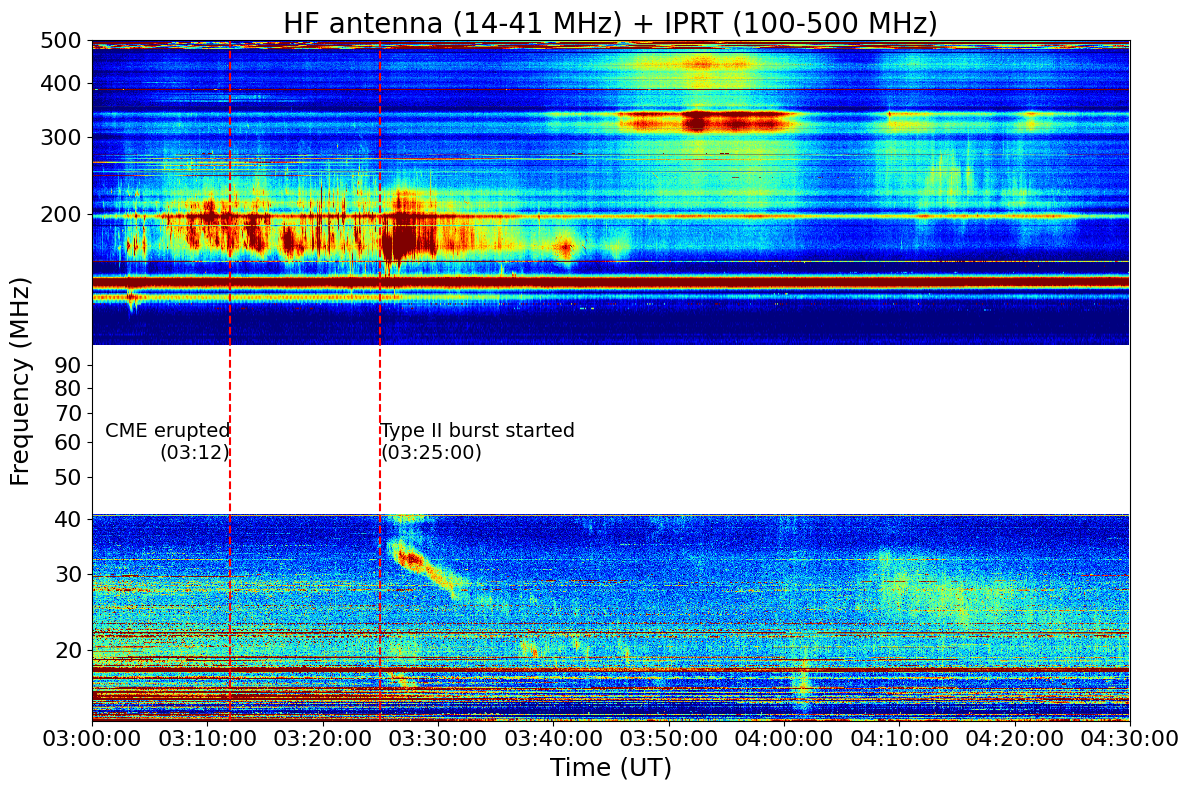

: 

In [12]:
plot_combined_dynamic_spectrum(start_time="2022-06-13 03:00:00",
                               end_time="2022-06-13 04:30:00")


# Learmonth (25-150MHz) + IPRT (150-500MHz)

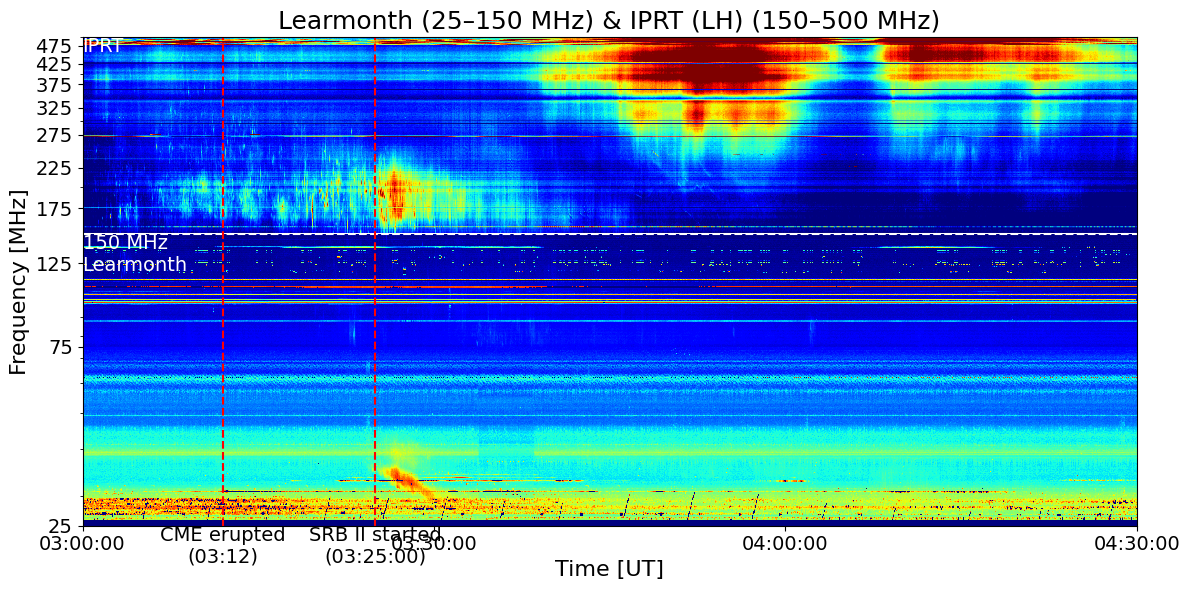

In [5]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt
import struct
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import pandas as pd
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

# ================================
# Learmonth 用関数
# ================================
def read_learmonth_srs(file_path):
    """
    Learmonth SRSファイルを読み込み，
    各レコードごとに時刻（文字列），
    2チャンネルを連結した周波数軸（MHz），
    強度（dBm）のデータを返す関数です．

    ※ レコードは826バイト（8バイトヘッダ + 2×(8バイトチャンネルヘッダ + 401バイトデータ)）と仮定．
       チャンネル1は約25～75 MHz（ヘッダ値÷256），
       チャンネル2は信頼性が低いため，周波数軸は75～180 MHzをlinspaceで作成．
    """
    with open(file_path, "rb") as f:
        data = f.read()
    
    record_size = 8 + 2 * (8 + 401)  # 826 bytes per record
    num_records = len(data) // record_size

    times = []
    frequencies = []
    intensities = []
    index = 0

    for rec in range(num_records):
        # --- レコードヘッダ（8バイト）の読み込み ---
        header = data[index:index+8]
        year, month, day, hour, minute, second, _, _ = struct.unpack("8B", header)
        index += 8
        # 年の補正: 90未満は2000年代，それ以外は1900年代とする
        if year < 90:
            year += 2000
        else:
            year += 1900
        timestamp = f"{year}-{month:02d}-{day:02d} {hour:02d}:{minute:02d}:{second:02d}"
        times.append(timestamp)

        # --- チャンネル1 ---
        ch1_header = data[index:index+8]
        # ※ヘッダ中必要な値のみを利用（start1, end1）
        start1, end1, resbw1, ref_level1, rnge1 = struct.unpack("3H2B", ch1_header)
        index += 8
        # 周波数軸（チャンネル1）：start1～end1 を401点でlinspace（値は256で割る）
        freq_ch1 = np.linspace(start1, end1, 401) / 256.0

        # チャンネル1データ（401バイト）
        raw_intensity1 = np.frombuffer(data[index:index+401], dtype=np.uint8)
        index += 401
        intensity1 = raw_intensity1.astype(np.int16)
        intensity1[intensity1 >= 128] -= 256

        # --- チャンネル2 ---
        # チャンネル2ヘッダは読み飛ばす（8バイト）
        index += 8
        # 周波数軸は強制的に75～180 MHzのlinspace（401点）
        freq_ch2 = np.linspace(75, 180, 401)
        # チャンネル2データ（401バイト）
        raw_intensity2 = np.frombuffer(data[index:index+401], dtype=np.uint8)
        index += 401
        intensity2 = raw_intensity2.astype(np.int16)
        intensity2[intensity2 >= 128] -= 256

        # 2チャンネルを連結（合計802点）
        full_freq = np.concatenate([freq_ch1, freq_ch2])
        full_intensity = np.concatenate([intensity1, intensity2])
        frequencies.append(full_freq)
        intensities.append(full_intensity)
    
    return times, np.array(frequencies), np.array(intensities)

# ================================
# IPRT 用関数群
# ================================
def load_fits_data(fits_file):
    """FITSファイルからデータとヘッダを取得"""
    with fits.open(fits_file) as hdul:
        data = hdul[0].data  # データ部分（通常は3次元）
        header = hdul[0].header
    return data, header

def generate_time_axis(header):
    """ヘッダの情報から時間軸（pandasのdate_range）を作成"""
    start_time = pd.Timestamp(f"{header['DATE-OBS']} {header['TIME-OBS']}")
    end_time = pd.Timestamp(f"{header['DATE-END']} {header['TIME-END']}")
    num_points = header['NAXIS1']
    return pd.date_range(start=start_time, end=end_time, periods=num_points)

def generate_frequency_axis(header):
    """ヘッダの情報から周波数軸を作成"""
    freq_start = header['CRVAL2']
    freq_step = header['CDELT2']
    num_freqs = header['NAXIS2']
    return np.linspace(freq_start, freq_start + freq_step * (num_freqs - 1), num_freqs)

# ================================
# LearmonthとIPRTを統合してプロットする関数
# ================================
def plot_combined_spectrum(lear_file, iprt_file,
                           start_time, end_time,
                           # 表示する周波数範囲：Learmonthは25～150MHz，IPRTは150～500MHz
                           learner_freq_min=25, learner_freq_max=150,
                           iprt_freq_min=150, iprt_freq_max=500,
                           # X軸の目盛間隔（秒）とY軸の固定目盛（MHz; 下側は両方に共通）
                           time_interval=30*60,
                           yticks_interval=25):
    """
    Learmonth と IPRT のデータを読み込み，指定時間内の
    Learmonth(25–150 MHz)とIPRT(150–500 MHz)を同一の時刻軸でプロットする．
    
    ※ 両データは intensity のカラースケールを共通（5th，95thパーセンタイル）にして表示する．
    """
    # ----- Learmonthデータの読み込みと時間・周波数軸の作成 -----
    times_str, full_freqs, intensities = read_learmonth_srs(lear_file)
    # 時刻文字列をdatetimeに変換
    times_dt = [datetime.strptime(t, "%Y-%m-%d %H:%M:%S") for t in times_str]
    # 指定時間内のインデックスを選択
    indices = [i for i, t in enumerate(times_dt) if start_time <= t <= end_time]
    if not indices:
        print("Learmonth: 指定時間内にデータがありません．")
        return
    selected_times = np.array(times_dt)[indices]
    # matplotlib用の数値形式に変換
    time_nums = mdates.date2num(selected_times)
    # 時間セルのエッジ（レコード間隔が均一と仮定）
    if len(time_nums) > 1:
        dt_num = time_nums[1] - time_nums[0]
    else:
        dt_num = 1/86400.0  # 1秒(=1/86400日)
    time_edges_lear = np.concatenate(([time_nums[0] - dt_num/2],
                                      (time_nums[:-1] + time_nums[1:]) / 2,
                                      [time_nums[-1] + dt_num/2]))
    # Learmonthは全レコードで同じ周波数軸を持つ（802点，25～180MHz）
    full_freq_axis = full_freqs[0]
    # Learmonthの表示範囲は learner_freq_min ～ learner_freq_max
    freq_mask_lear = (full_freq_axis >= learner_freq_min) & (full_freq_axis <= learner_freq_max)
    if not np.any(freq_mask_lear):
        print("Learmonth: 指定周波数内にデータがありません．")
        return
    freq_axis_lear = full_freq_axis[freq_mask_lear]
    # 対応する intensity を抜き出す
    learner_data = intensities[indices, :][:, freq_mask_lear]
    # 周波数セルエッジの計算
    df = np.diff(freq_axis_lear)
    df_first = df[0] if len(df)>0 else 0.1
    freq_edges_lear = np.concatenate(([freq_axis_lear[0] - df_first/2],
                                      (freq_axis_lear[:-1] + freq_axis_lear[1:]) / 2,
                                      [freq_axis_lear[-1] + df[-1]/2]))



    # ----- IPRTデータの読み込みと時間・周波数軸の作成 -----
    data_iprt, header_iprt = load_fits_data(iprt_file)
    # IPRTデータは通常 data[0, :, :] で (freq, time) の形状を想定
    # 時間軸，周波数軸の生成
    iprt_time_axis = generate_time_axis(header_iprt)
    iprt_freq_axis = generate_frequency_axis(header_iprt)
    # 指定時間に合わせてマスク（pandas Timestamp同士で比較）
    # ※floor/ceilで秒単位に補正
    start_time_iprt = pd.Timestamp(start_time).floor('s')
    end_time_iprt = pd.Timestamp(end_time).ceil('s')
    time_mask_iprt = (iprt_time_axis >= start_time_iprt) & (iprt_time_axis <= end_time_iprt)
    # 指定周波数（iprt_freq_min ～ iprt_freq_max）のマスク
    freq_mask_iprt = (iprt_freq_axis >= iprt_freq_min) & (iprt_freq_axis <= iprt_freq_max)
    if np.sum(time_mask_iprt)==0 or np.sum(freq_mask_iprt)==0:
        print("IPRT: 指定時間または周波数内にデータがありません．")
        return
    # IPRTデータはヘッダより data[0, freq, time] と想定
    iprt_data = data_iprt[1, freq_mask_iprt, :][:, time_mask_iprt]
    trimmed_iprt_time = iprt_time_axis[time_mask_iprt]
    trimmed_iprt_freq = iprt_freq_axis[freq_mask_iprt]
    # IPRTの場合は imshow 用に extent を作成．
    t0_iprt = mdates.date2num(trimmed_iprt_time[0])
    t1_iprt = mdates.date2num(trimmed_iprt_time[-1])
    f0_iprt = trimmed_iprt_freq[0]
    f1_iprt = trimmed_iprt_freq[-1]

    # ----- カラースケール（vmin,vmax）の共通設定 -----
    # それぞれのデータの5th, 95thパーセンタイルから計算
    vmin_lear = np.percentile(learner_data, 5)
    vmax_lear = np.percentile(learner_data, 95)
    vmin_iprt = np.percentile(iprt_data, 5)
    vmax_iprt = np.percentile(iprt_data, 95)
    vmin = min(vmin_lear, vmin_iprt)
    vmax = max(vmax_lear, vmax_iprt)

    # ----- プロット作成 -----
    fig, ax = plt.subplots(figsize=(12, 6))

    # Learmonth (25-150 MHz) のプロット（pcolormesh）
    # 軸： x = 時間 edges, y = 周波数 edges, データ = learner_data.T (転置して周波数×時間)
    mesh1 = ax.pcolormesh(time_edges_lear, freq_edges_lear, learner_data.T,
                          shading='auto', cmap='jet', vmin=vmin, vmax=vmax)

    # IPRT (150-500 MHz) のプロット
    # IPRTデータは imshow を利用．extent=[time_min, time_max, freq_min, freq_max] を設定
    # ※ iprt_data の shape は (Nfreq, Ntime) なので，origin='lower'で正しい向きに表示
    img2 = ax.imshow(iprt_data, aspect='auto', origin='lower',
                     extent=[t0_iprt, t1_iprt, f0_iprt, f1_iprt],
                     cmap='jet', vmin=vmin, vmax=vmax)

    # # カラーバーの作成（Learmonth, IPRT どちらでもよい）
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="2%", pad=0.1)
    # cbar = plt.colorbar(mesh1, cax=cax)
    # cbar.set_label("Intensity", fontsize=14)
    # cbar.ax.tick_params(labelsize=12)
    
    # 平行線とテキスト
    ax.hlines(150, xmin=mdates.date2num(start_time), xmax=mdates.date2num(end_time), colors='white', linestyles='dashed', linewidth=1.5)
    ax.text(mdates.date2num(start_time), 150, '150 MHz\nLearmonth', color='white', fontsize=14, verticalalignment='top')
    ax.text(mdates.date2num(start_time), iprt_freq_max, 'IPRT', color='white', fontsize=14, verticalalignment='top')
    
      # 垂直線とテキストの表示
    ax.vlines(pd.Timestamp('2022-06-13 03:12:00'), learner_freq_min, iprt_freq_max, color='red', linestyle='--')
    ax.text(pd.Timestamp('2022-06-13 03:12:00'), learner_freq_min, 'CME erupted\n(03:12)', color='Black', fontsize=14, ha='center', va='top')
    ax.vlines(pd.Timestamp('2022-06-13 03:25:00'), learner_freq_min, iprt_freq_max, color='red', linestyle='--')
    ax.text(pd.Timestamp('2022-06-13 03:25:00'), learner_freq_min, 'SRB II started\n(03:25:00)', color='Black', fontsize=14, ha='center', va='top')

    # 軸設定
    ax.set_xlim(mdates.date2num(start_time), mdates.date2num(end_time))
    ax.set_ylim(learner_freq_min, iprt_freq_max)
    ax.set_xlabel("Time [UT]", fontsize=16)
    ax.set_ylabel("Frequency [MHz]", fontsize=16)
    ax.set_title("Learmonth (25–150 MHz) & IPRT (LH) (150–500 MHz)", fontsize=18)

    # X軸： 時刻表示（秒間隔）
    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=time_interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    # Y軸： 対数スケールにし，固定の目盛を設定
    ax.set_yscale("log")
    # 例： 25MHz刻みの目盛（必要に応じ調整）
    y_ticks = np.arange(learner_freq_min, iprt_freq_max+yticks_interval, yticks_interval)
    ax.yaxis.set_major_locator(mticker.FixedLocator(y_ticks))
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
    ax.tick_params(axis='both', labelsize=14)

    plt.tight_layout()
    plt.show()

# ================================
# メイン処理
# ================================
if __name__ == "__main__":
    # Learmonthファイルのパス
    learner_file_path = "/home/kinno-7010/Research/Radio data/Learmonth/Rawdata/LM220613.srs"
    # IPRT FITSファイルのパス
    iprt_file_path = "/home/kinno-7010/Research/Radio data/IPRT/Rawdata/20220613_IPRT.fits"
    
    # プロットする時間範囲の設定（例：2022-06-13 03:00:00 ～ 04:30:00）
    start_time = datetime(2022, 6, 13, 3, 0, 0)
    end_time   = datetime(2022, 6, 13, 4, 30, 0)
    
    # Learmonthは25～150MHz，IPRTは150～500MHz
    # X軸の目盛（秒間隔）や Y軸の目盛刻みは必要に応じ調整してください．
    plot_combined_spectrum(learner_file_path, iprt_file_path,
                           start_time, end_time,
                           learner_freq_min=25, learner_freq_max=150,
                           iprt_freq_min=150, iprt_freq_max=500,
                           time_interval=30*60,  # 30分毎
                           yticks_interval=50)   # 25MHz毎（例）
